In [1]:
import pandas as pd
import numpy as np

# Load Lorenz Data
file_path = 'LorenzData.csv'  # Replace with your actual file path

# Assuming the file does not have a header, use header=None
lorenz_data = pd.read_csv('LorenzData.csv', header=None)

# Define Parameters
lambda_val = 0.6 # Regularization Parameter
dt = 0.001  # Time Step
tmax = 20  # Maximum Time

# Identify Columns
# Assuming the order of columns corresponds to (0, 1, 2) or (x, y, z)
# If the columns are not labeled, you may adjust the column indices accordingly
# For example, if columns are (0, 1, 2), set x_col = 0, y_col = 1, z_col = 2
x_col, y_col, z_col = 0,1,2

# Extract data
#time_column = 0  # Assuming the first column is time

x_values = lorenz_data.iloc[:, x_col].values
y_values = lorenz_data.iloc[:, y_col].values
z_values = lorenz_data.iloc[:, z_col].values

# Display loaded data and parameters
print("Lorenz Data:")
print(lorenz_data.head())

print("\nParameters:")
print(f"Regularization Parameter (lambda): {lambda_val}")
print(f"Time Step (dt): {dt}")
print(f"Maximum Time (tmax): {tmax}")



# Compute Derivatives
dxdt = np.gradient(x_values, dt)
dydt = np.gradient(y_values, dt)
dzdt = np.gradient(z_values, dt)
#Stack the derivatives into a single array
dXdt = np.column_stack([dxdt, dydt,dzdt])

# Display computed derivatives
print("Computed Derivatives (dx/dt, dy/dt,dz/dt):")
print(dXdt)

# Normalize Theta

import numpy as np

# Assuming dXdt, x_values, y_values, z_values are already defined from previous steps

# Construct Design Matrix Theta(X)
# Include constants (1), individual variables (x, y, z), and their products
# Add non-linear terms, e.g., x^2, y^2, z^2, and trigonometric functions (cos and sin)

# Uncomment the portions below depending on the dimension (column size of X)
# For three-dimensional problems:

Theta = np.column_stack([
  np.ones_like(x_values),  # Constants
  x_values, y_values, z_values,  # Individual variables
  x_values * y_values, y_values * z_values, x_values * z_values,  # Products
  x_values**2, y_values**2, z_values**2,  # Squared terms
  np.cos(x_values), np.cos(y_values), np.cos(z_values),  # Trigonometric functions
  np.sin(x_values), np.sin(y_values), np.sin(z_values)
])

#or two-dimensional problems:
#Uncomment the portions below for 2-dimensional problems
#Theta = np.column_stack([
  # x_values, y_values, x_values * y_values,
  # x_values**2, y_values**2, np.cos(x_values), np.cos(y_values),
   #np.sin(x_values), np.sin(y_values)
#])

# Display the constructed design matrix
print("Constructed Design Matrix Theta(X):")
print(Theta)

# Initialize Unknown Coefficients Xi using least squares regression

# Calculate the pseudoinverse of Theta
Theta_pseudoinv = np.linalg.pinv(Theta)

# Solve for Xi_initial
Xi_initial = np.dot(Theta_pseudoinv, dXdt)

# Display the initial coefficients
print("Initial Unknown Coefficients (Xi_initial):")
print(Xi_initial)


import numpy as np

# Assuming Xi_initial, Theta, and dXdt are already defined from previous steps
# Also, lambda_val should be defined as your regularization parameter

# SINDy Iterative Algorithm
Xi = Xi_initial.copy()  # Copy the initial coefficients

# Number of iterations (adjust as needed)
num_iterations = 100

for iteration in range(num_iterations):
    # Identify small coefficients and set them to zero based on a threshold (lambda)
    small_indices = np.abs(Xi) < lambda_val
    Xi[small_indices] = 0

    # For each dimension (x, y, z), perform a least squares regression to update non-zero coefficients
    for idx in range(Xi.shape[1]):
        # Identify indices with non-zero coefficients
        non_zero_indices = ~small_indices[:, idx]

        # Re-evaluate Xi at the indices where values are greater than lambda
        if np.any(non_zero_indices):
            # Calculate the pseudoinverse of the submatrix of Theta
            Theta_submatrix = Theta[:, non_zero_indices]
            Theta_submatrix_pseudoinv = np.linalg.pinv(Theta_submatrix)

            # Solve for the updated coefficients
            Xi[non_zero_indices, idx] = np.dot(Theta_submatrix_pseudoinv, dXdt[:, idx])

# Display the final coefficients after the SINDy iterative algorithm
print("Final Unknown Coefficients (Xi):")
print(Xi)

Lorenz Data:
          0        1       2
0  0.000000  1.00000  20.000
1  0.010000  0.99900  19.947
2  0.019890  0.99808  19.893
3  0.029672  0.99724  19.840
4  0.039348  0.99649  19.788

Parameters:
Regularization Parameter (lambda): 0.6
Time Step (dt): 0.001
Maximum Time (tmax): 20
Computed Derivatives (dx/dt, dy/dt,dz/dt):
[[ 10.     -1.    -53.   ]
 [  9.945  -0.96  -53.5  ]
 [  9.836  -0.88  -53.5  ]
 ...
 [ 21.7    37.35  -22.   ]
 [ 21.85   37.65  -21.5  ]
 [ 21.9    37.8   -21.   ]]
Constructed Design Matrix Theta(X):
[[ 1.          0.          1.         ...  0.          0.84147098
   0.91294525]
 [ 1.          0.01        0.999      ...  0.00999983  0.84093026
   0.89004509]
 [ 1.          0.01989     0.99808    ...  0.01988869  0.84043205
   0.86414257]
 ...
 [ 1.          3.4337      5.6103     ... -0.28797094 -0.62324497
   0.25801132]
 [ 1.          3.4555      5.6478     ... -0.3087774  -0.59348767
   0.2792023 ]
 [ 1.          3.4774      5.6856     ... -0.32953153 -0.5

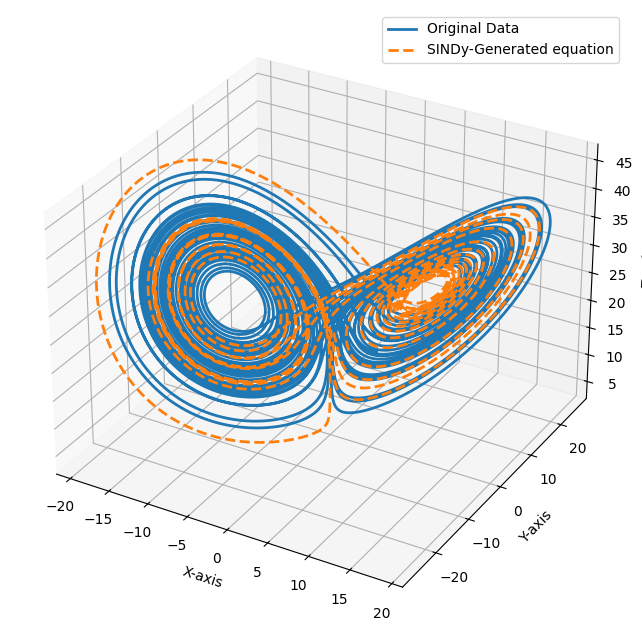

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
# Define time range
tmax = 20
num_points = len(x_values)  # Use the number of existing time points
t = np.linspace(0, tmax, num_points)
# Assuming you have the initial conditions
initial_conditions = [0,1 ,20 ]  # Replace x0, y0, z0 with your actual initial values



# Define the Lorenz system differential equations
def lorenz_system(X, t):
    x, y, z = X
    dxdt = Xi[0, 0] + Xi[1, 0] * x + Xi[2, 0] * y + Xi[3, 0] * z + \
           Xi[4, 0] * x * y + Xi[5, 0] * y * z + Xi[6, 0] * x * z + \
           Xi[7, 0] * x**2 + Xi[8, 0] * y**2 + Xi[9, 0] * z**2 + \
           Xi[10, 0] * np.cos(x) + Xi[11, 0] * np.cos(y) + Xi[12, 0] * np.cos(z) + \
           Xi[13, 0] * np.sin(x) + Xi[14, 0] * np.sin(y) + Xi[15, 0] * np.sin(z)
    dydt = Xi[0, 1] + Xi[1, 1] * x + Xi[2, 1] * y + Xi[3, 1] * z + \
           Xi[4, 1] * x * y + Xi[5, 1] * y * z + Xi[6, 1] * x * z + \
           Xi[7, 1] * x**2 + Xi[8, 1] * y**2 + Xi[9, 1] * z**2 + \
           Xi[10, 1] * np.cos(x) + Xi[11, 1] * np.cos(y) + Xi[12, 1] * np.cos(z) + \
           Xi[13, 1] * np.sin(x) + Xi[14, 1] * np.sin(y) + Xi[15, 1] * np.sin(z)
    dzdt = Xi[0, 2] + Xi[1, 2] * x + Xi[2, 2] * y + Xi[3, 2] * z + \
           Xi[4, 2] * x * y + Xi[5, 2] * y * z + Xi[6, 2] * x * z + \
           Xi[7, 2] * x**2 + Xi[8, 2] * y**2 + Xi[9, 2] * z**2 + \
           Xi[10, 2] * np.cos(x) + Xi[11, 2] * np.cos(y) + Xi[12, 2] * np.cos(z) + \
           Xi[13, 2] * np.sin(x) + Xi[14, 2] * np.sin(y) + Xi[15, 2] * np.sin(z)
    return [dxdt, dydt, dzdt]

# Simulate the Lorenz system using odeint
X_sindy = odeint(lorenz_system, initial_conditions, t)

# Plot Original Data and SINDy-Generated Data in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Original Data
ax.plot(x_values, y_values, z_values, label='Original Data', linewidth=2)

# Plot SINDy-Generated Data
ax.plot(X_sindy[:, 0], X_sindy[:, 1], X_sindy[:, 2], linestyle='dashed', label='SINDy-Generated equation', linewidth=2)

# Set labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()
plt.savefig('sindy_plot.png')
# Show the plot
plt.show()

In [3]:
# Assuming X_sindy is already defined from previous steps
# Compare with the original data
rmse = np.sqrt(np.mean((X_sindy - lorenz_data)**2))

# Display RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 11.953642521593846


In [4]:
non_zero_count = np.count_nonzero(Xi)

print(non_zero_count)


7


In [5]:
mae = np.mean(np.abs(X_sindy -lorenz_data ))
print(mae)             


9.744164784013858
